# Example of spatial analysis on a region in pancreatic cancer

## Note: calculating mpp for the slide

The slide we are interested in does not have the property "openslide.mpp-x", so instead, I used `tiff.ResolutionUnit` along with `tiff.XResolution`. The resolution unit is centimeters, and xresolution (I think) is pixels per resolution unit. So I did this...

$$
\frac{ResolutionUnit}{XResolution} * \frac{N micrometer}{ResolutionUnit}
$$

where $N micrometer$ is the number of micrometers in one unit of $ResolutionUnit$.

In our case, this was

$$
\frac{1 cm}{2883.244194 pix} * \frac{10,000 \mu m}{1 cm} = 0.34622 \frac{\mu m}{pix}
$$

In [1]:
from pathlib import Path
import tumor_microenv as tm

In [2]:
data_root = Path("data") / "Div_Data"  # 25 micrometer
patch_paths = list(data_root.glob("*.npy"))
json_paths = list(data_root.glob("*.json"))

loader = tm.LoaderV1(
    patch_paths=patch_paths, 
    cells_json=json_paths, 
    background=0, 
    marker_positive=1, 
    marker_negative=7,
)
patches, cells = loader()
# Optionally filter cells by some condition.
cells = [c for c in cells if c.cell_type in {"cd4", "cd8", "cd16", "cd163"}]

In [ ]:
# This takes several minutes.
tm.run_spatial_analysis(
    patches, 
    cells, 
    microenv_distances=[100], 
    mpp=0.34622,
    output_path="output-25micron-dev.csv")

In [4]:
!du -sh output-25micron-dev.csv

144M	output-25micron-dev.csv


# Make histograms from output CSV

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
mpp = 0.34622
df = pd.read_csv("output-25micron-dev.csv")
df.loc[:, "dist_to_marker_neg"] *= mpp
df.loc[:, "dist_to_marker_pos"] *= mpp
df.head()

,point,dist_to_marker_neg,dist_to_marker_pos,line_to_marker_neg,line_to_marker_pos,cell_type,cell_uuid,microenv_micrometer
0,POINT (41538 25602),50.54812,0.0,"LINESTRING (41538 25602, 41392 25602)","LINESTRING (41538 25602, 41538 25602)",cd163,5a8bf96c21454445abcfbcc184e4b629,200
1,POINT (41538 25603),50.54812,0.0,"LINESTRING (41538 25603, 41392 25603)","LINESTRING (41538 25603, 41538 25603)",cd163,5a8bf96c21454445abcfbcc184e4b629,200
2,POINT (41538 25604),50.54812,0.0,"LINESTRING (41538 25604, 41392 25604)","LINESTRING (41538 25604, 41538 25604)",cd163,5a8bf96c21454445abcfbcc184e4b629,200
3,POINT (41538 25605),50.54812,0.0,"LINESTRING (41538 25605, 41392 25605)","LINESTRING (41538 25605, 41538 25605)",cd163,5a8bf96c21454445abcfbcc184e4b629,200
4,POINT (41538 25606),50.54812,0.0,"LINESTRING (41538 25606, 41392 25606)","LINESTRING (41538 25606, 41538 25606)",cd163,5a8bf96c21454445abcfbcc184e4b629,200


In [7]:
df.shape

(874757, 8)

In [8]:
def get_pdf_and_cdf(values, bins=100):
    values = np.asarray(values)
    count, bins = np.histogram(values, bins=100)
    pdf = count / count.sum()
    cdf = pdf.cumsum()
    return pdf, cdf, bins

def plot_pdf_cdf(pdf, cdf, bins, cell_type, marker_type, ax):
    ax.plot(bins[1:], pdf, color="red", label="PDF")
    ax.plot(bins[1:], cdf, label="CDF")
    ax.legend()
    ax.set_xlabel("Distance (micrometer)")
    ax.set_title(f"{cell_type} distance to marker {marker_type}")
    return ax

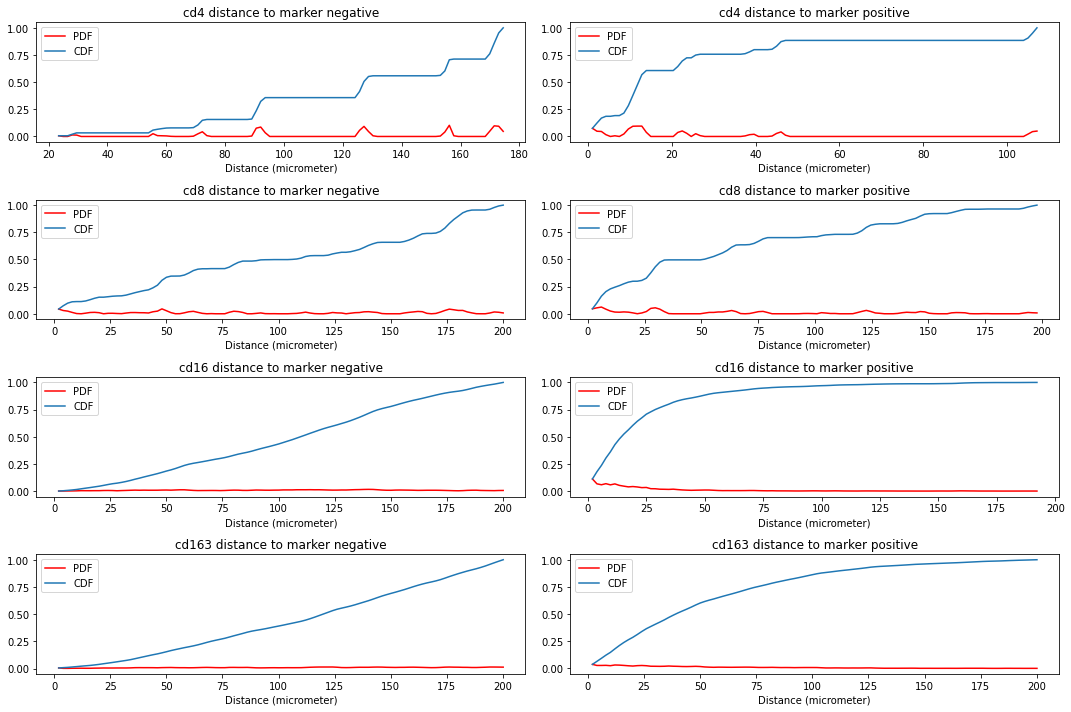

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
cell_types = ["cd4", "cd8", "cd16", "cd163"]
for i, cell_type in enumerate(cell_types):
    for j, (marker_status, column)  in enumerate(
        [("negative", "dist_to_marker_neg"), ("positive", "dist_to_marker_pos")]):
        
        # Multiply pixels by mpp to get distance in micrometers.
        pdf, cdf, bins = get_pdf_and_cdf(df.query(f"cell_type=='{cell_type}'").loc[:, column])
        plot_pdf_cdf(pdf, cdf, bins, cell_type=cell_type, marker_type=marker_status, ax=axes[i, j])
fig.tight_layout()
plt.savefig("/tmp/hist.pdf")

### Plot again but now with one plot per cell type (include M+ and M- in same plot)

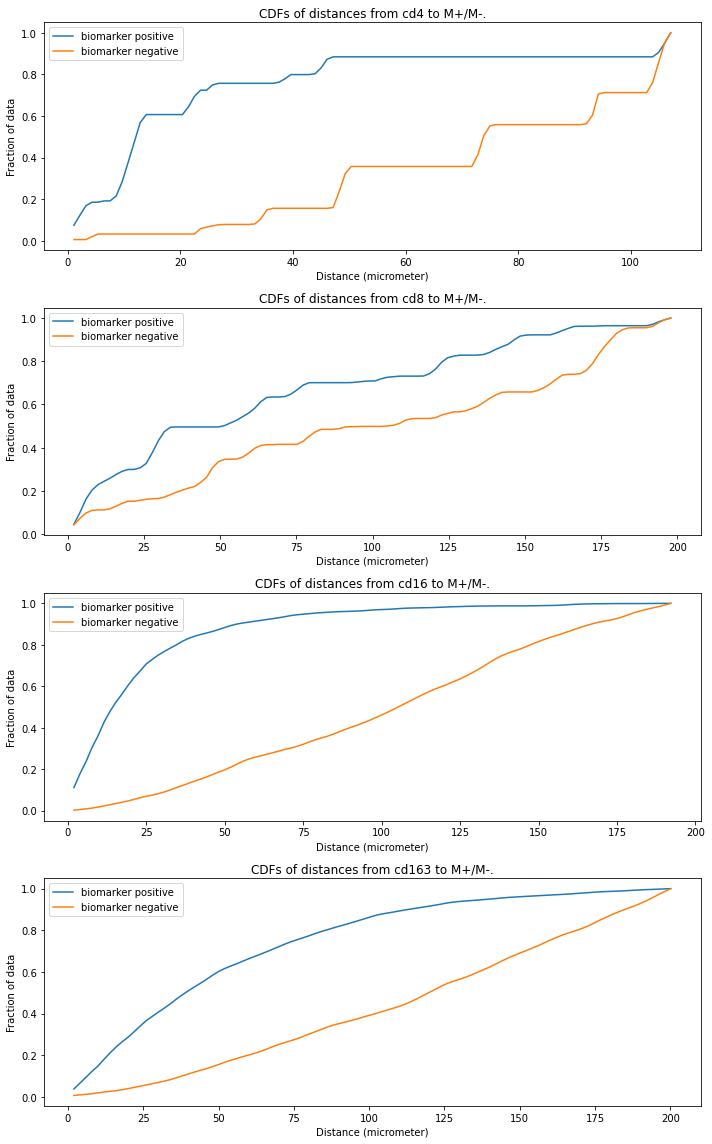

In [10]:
def plot_cdfs_per_celltype(cdf_pos, cdf_neg, bins, cell_type, ax):
    ax.plot(bins[1:], cdf_pos, label="biomarker positive")
    ax.plot(bins[1:], cdf_neg, label="biomarker negative")
    ax.legend()
    ax.set_xlabel("Distance (micrometer)")
    ax.set_ylabel("Fraction of data")
    ax.set_title(f"CDFs of distances from {cell_type} to M+/M-.")
    return ax

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 16))
cell_types = ["cd4", "cd8", "cd16", "cd163"]
for i, cell_type in enumerate(cell_types):
    _tmp_df = df.query(f"cell_type=='{cell_type}'")
    _, cdf_neg, bins = get_pdf_and_cdf(_tmp_df.loc[:, "dist_to_marker_neg"])
    _, cdf_pos, bins = get_pdf_and_cdf(_tmp_df.loc[:, "dist_to_marker_pos"])
    plot_cdfs_per_celltype(
        cdf_pos=cdf_pos, cdf_neg=cdf_neg, bins=bins, cell_type=cell_type, ax=axes[i])

fig.tight_layout()
plt.savefig("/tmp/cdfs.pdf")
plt.show()

In [11]:
# TODO: add KS test

# Overlay patches and points on IHC

In [15]:
from collections import Counter
from pathlib import Path

In [16]:
data_root = Path("data/Div_Data/")
patch_paths = list(data_root.glob("*.npy"))
json_paths = list(data_root.glob("*.json"))

loader = tm.LoaderV1(
    patch_paths=patch_paths, 
    cells_json=json_paths, 
    background=0,
    marker_positive=1, 
    marker_negative=7,
)
patches, cells = loader()
cells = [c for c in cells if c.cell_type in {"cd3", "cd4", "cd8", "cd16", "cd163"}]

Counter(patch.patch_type for patch in patches)

Counter({<PatchType.NONTUMOR: 2>: 3422,
         <PatchType.TUMOR: 1>: 1845,
         <PatchType.BLANK: 0>: 1789})

In [17]:
points_data = tm.read_point_csv("output-25micron-dev.csv")

In [18]:
tm.overlay_patches_and_points(
    image_path="data/merged_image.png", 
    patches=patches, 
    points_data=points_data, 
    output_path="overlay.png")